In [9]:
#import user modules
import utils.helper_functions as hfun
import config as cf
import modules.thouless_times as thouless
import modules.spectral_functions as spec_fun
import modules.sff as sff_module
import modules.adiabatics as agp
import modules.anderson as anderson
import importlib
from utils.fit_functions import *
def reload_modules():
    importlib.reload(anderson)
    importlib.reload(hfun)
    importlib.reload(cf)
    importlib.reload(thouless)
    importlib.reload(spec_fun)
    importlib.reload(agp)
    importlib.reload(sff_module)

reload_modules()

from utils.fit_functions import *
#--- importet in user module
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
import os
from utils import exit
from os import sep as kPSep
from os.path import exists

#--- other modules
import numpy as np
import itertools
import seaborn as sns
import pandas as pd
import math
import random
import imageio
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from joblib import Parallel, delayed
import copy
#plt.style.use(['science','ieee','no-latex'])

# get all the colors
import matplotlib.colors as mcolors
from scipy.special import binom
import sympy as sym
from scipy.optimize import curve_fit as fit

print(cf.base_directory)
from cmath import nan
import h5py    


user_settings = getattr(cf.plot_settings, 'settings')


../results/Heisenberg/disorder/PBC/


Keys: <KeysViewHDF5 ['energies', 'entropy']>
256 28 228
Keys: <KeysViewHDF5 ['energies', 'entropy']>
1024 412 612
Keys: <KeysViewHDF5 ['energies', 'entropy']>
4096 1948 2148
Keys: <KeysViewHDF5 ['energies', 'entropy']>
16384 8092 8292


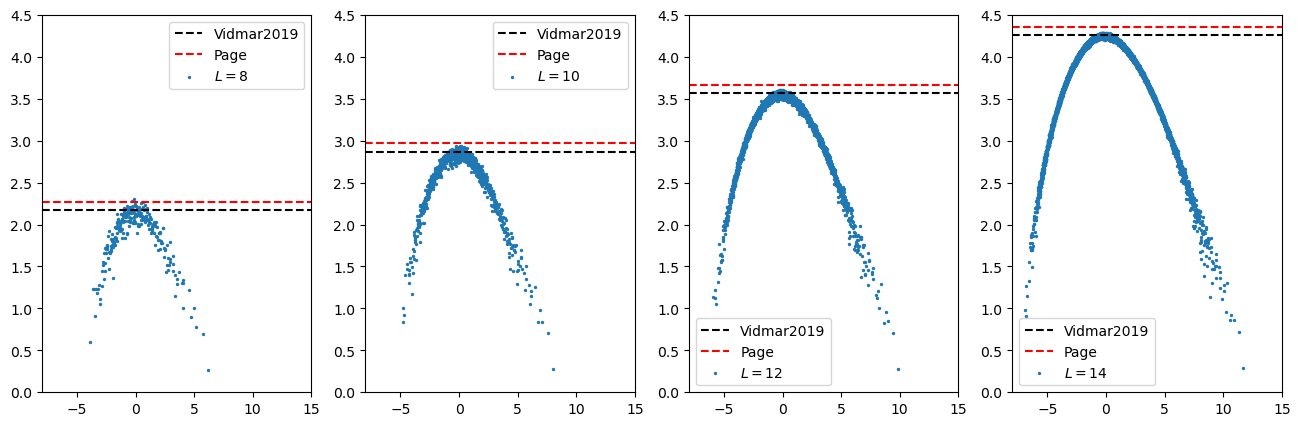

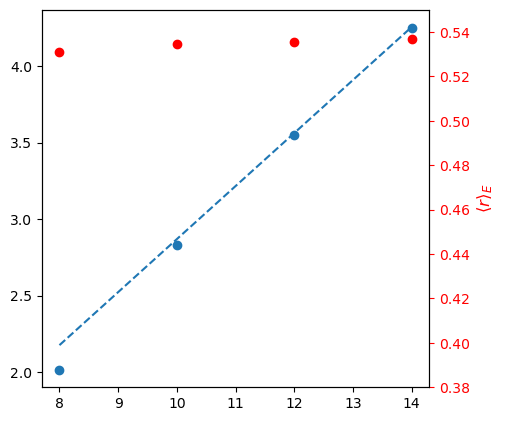

In [100]:
from statistics import mean


dir = "../results/XYZ/disorder/OBC/Entropy/Eigenstate/"
L=10
J=0.5
J0=0.5
g=0.9
g0=0.9
h=0.8
w=0.2

fig, ax = plt.subplots( nrows=1, ncols=4, figsize=(16,5), dpi = 100)

validL = []
Smean = []
gap_ratio = []
def plot_here(axis, L):
    info = hfun.info_dis(L, J, J0, g, g0, h, w)
    info = dir + info[0 : info.index('.dat') :]
    
    Smax = L * np.log(2) / 2. + (0.5 - np.log(2)) / 2. - 0.5
    Spage = L * np.log(2) / 2. - 0.5
    filename = info + "_subsize=%d.hdf5"%(L/2)
    if exists(filename):
        data = []
        with h5py.File(filename, "r") as f:
            # Print all root level object names (aka keys) 
            # these can be group or dataset names 
            print("Keys: %s" % f.keys())
            # get first object name/key; may or may NOT be a group
            a_group_key = list(f.keys())[1]
            data = []
            for key in list(f.keys()):
                data.append(np.array(f[key][0]))
        
        axis.scatter(data[0], data[1], label=r"$L=%d$"%L,s=2)
        axis.axhline(y=Smax, linestyle='--', color='black', label="Vidmar2019")
        axis.axhline(y=Spage, linestyle='--', color='red', label="Page")
        axis.set_ylim(0, 4.5)
        axis.set_xlim(-8, 15)
        axis.legend()

        # get mean
        size = data[1].size
        my_min = int(0.5 * size - 100)
        my_max = int(0.5 * size + 100)
        print(size, my_min, my_max)
        
        sample = data[1][my_min : my_max]
        
        meanS = np.mean(sample)
        validL.append(L)
        Smean.append(meanS)
        gaps = np.diff(data[0])
        ratio = 0
        counter = 0
        for i in range(int(0.25 * size), int(0.75 * size)):
            ratio += min(gaps[i], gaps[i + 1]) / max(gaps[i], gaps[i + 1])
            counter += 1
        gap_ratio.append(ratio / counter)


plot_here(axis=ax[0], L=8)
plot_here(axis=ax[1], L=10)
plot_here(axis=ax[2], L=12)
plot_here(axis=ax[3], L=14)

#def page(L):    
#    return L * np.log(2) / 2. - 0.5
def Srand(L): 
    return L * np.log(2) / 2. + (0.5 - np.log(2)) / 2. - 0.5
#Ls = np.array(range(7,17))
validL = np.array(validL)
#ax[3].scatter(validL, np.abs(np.array(Smean) - page(validL)), label=r"$\langle S\rangle_{200\ states}-S_{page}$")
#ax[3].plot(Ls, np.abs(Srand(Ls) - page(Ls)), linestyle='--', label=r"$S_{rand}-S_{page}$")
#ax[3].legend()
#ax[3].set_xlim(6, 18)
#ax[3].set_xscale('log')
#ax[3].set_yscale('log')

fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 100)
ax_1 = ax.twinx()
ax.scatter(validL, Smean, label=r"$\langle S\rangle_{200 states}$")
ax.plot(validL, Srand(validL), linestyle='--', label=r"$S_{rand}$")
ax_1.scatter(validL, gap_ratio, color='red')
ax_1.set_ylim(0.38, 0.55)
ax_1.set_ylabel(r"$\langle r\rangle_E$", color='red', fontsize=12)
ax_1.tick_params(axis='y', color='red', labelcolor='red')